In [5]:
from DSA import SimulationConst
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

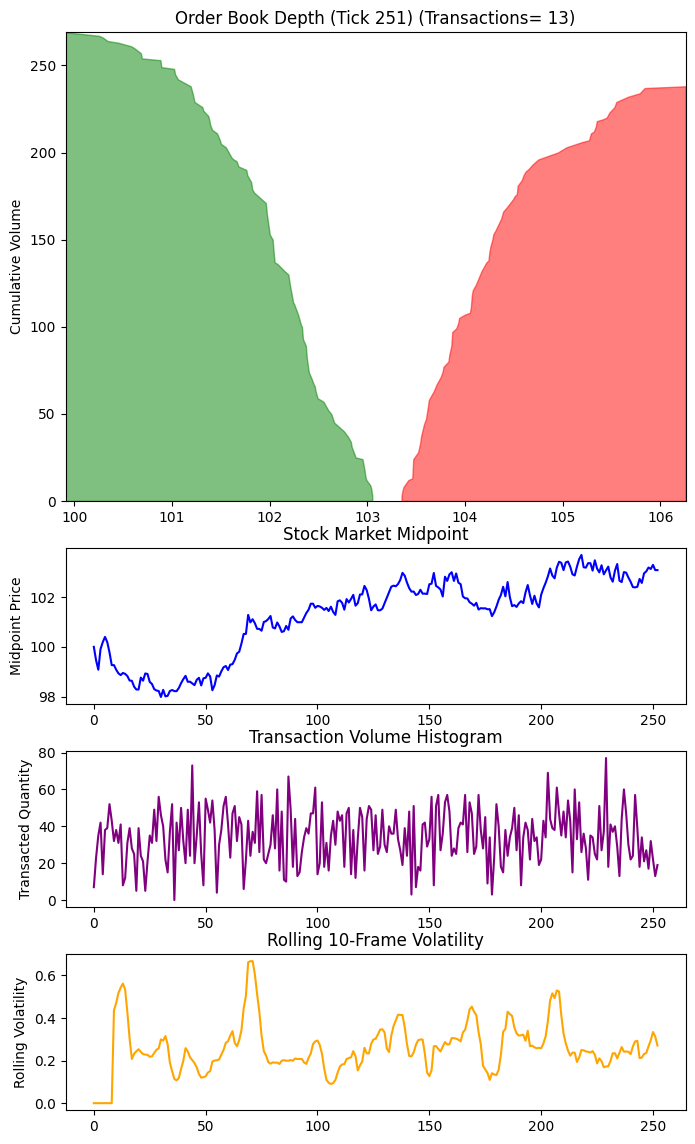

In [6]:
rng = np.random.default_rng(42)
N=252
simulation = SimulationConst(
    r=0.05, 
    sigma=0.2, 
    T=1.0, 
    N=N, 
    removal_percentage=0.1,
    bid_count_fn=lambda rng: rng.integers(0, 50),
    ask_count_fn=lambda rng: rng.integers(0, 50),
    initial_bid_price=99.0,
    initial_ask_price=101.0,
    rng=rng,
    initial_bid_orders=[(99.0,  55.0), (98.0,  50.0), (97.0,  25.0), (97.0,  25.0), (97.0,  25.0)],
    initial_ask_orders=[(101.0, 55.0), (102.0, 50.0), (103.0, 25.0), (103.0, 25.0), (103.0, 25.0)],
)

# Set up the figure and axes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 14), gridspec_kw={'height_ratios': [3, 1, 1, 1]})
ax1.set_xlim(85, 110)
ax1.set_ylabel("Cumulative Volume")
ax1.set_title("Order Book Depth")

ax2.set_ylabel("Midpoint Price")
ax2.set_title("Stock Market Midpoint")

ax3.set_ylabel("Transacted Quantity")
ax3.set_title("Transaction Volume Histogram")

ax4.set_ylabel("Rolling Volatility")
ax4.set_title("Rolling 10-Frame Volatility")

# Initialize data storage
midpoint_prices = []
transaction_volumes = []
rolling_volatility = []

# Preallocate plot objects
bid_area = ax1.fill_between([], [], color='green', alpha=0.5)
ask_area = ax1.fill_between([], [], color='red', alpha=0.5)
midpoint_line, = ax2.plot([], [], color='blue')
volume_line, = ax3.plot([], [], color='purple')
volatility_line, = ax4.plot([], [], color='orange')

# Function to compute rolling volatility
def compute_volatility(prices, window=10):
    if len(prices) < window:
        return 0
    return np.std(prices[-window:])

# Function to update animation frame
def update(frame: int):
    step = simulation.do_simulation_step()
    midpoint = (step.top_ask + step.top_bid) / 2
    midpoint_prices.append(midpoint)
    rolling_volatility.append(compute_volatility(midpoint_prices))
    transaction_quantity = sum(t.quantity for t in step.transactions)
    transaction_volumes.append(transaction_quantity)
    
    # Update midpoint price plot
    midpoint_line.set_data(range(len(midpoint_prices)), midpoint_prices)
    ax2.relim()
    ax2.autoscale_view()
    
    # Update volumes
    volume_line.set_data(range(len(transaction_volumes)), transaction_volumes)
    ax3.relim()
    ax3.autoscale_view()
    
    # Update rolling volatility plot
    volatility_line.set_data(range(len(rolling_volatility)), rolling_volatility)
    ax4.relim()
    ax4.autoscale_view()
    
    # Remove old order book depth areas properly
    for collection in ax1.collections:
        collection.remove()
    
    # Update order book depth
    depths = step.depths
    bid_prices = list(depths[0].keys())
    bid_volumes = list(depths[0].values())
    ask_prices = list(depths[1].keys())
    ask_volumes = list(depths[1].values())
    
    ax1.fill_between(bid_prices, bid_volumes, color='green', alpha=0.5)
    ax1.fill_between(ask_prices, ask_volumes, color='red', alpha=0.5)
    ax1.set_xlim(min(min(bid_prices), min(ask_prices)), max(max(bid_prices), max(ask_prices)))
    ax1.set_ylim(0, max(bid_volumes + ask_volumes, default=50))  # Adjust dynamically
    ax1.set_ylabel("Cumulative Volume")
    ax1.set_title(f"Order Book Depth (Tick {frame}) (Transactions={len(step.transactions):>3})")

# Create animation
ani = animation.FuncAnimation(fig, update, frames=N, repeat=False, interval=10)

# Save as 30fps video
ani.save("CLOB_3.demo.mp4", fps=15, extra_args=['-vcodec', 'libx264'])

# Display animation
plt.show()